# Applying LLE to the Leaf Sample data
LLE assumes two things
1. That the manifold is continuous (i.e. has no holes)
2. The the data is not noisy

These is also a further restriction that the number of neighbors in the K-NN algorithm in the first step must be greater than d, the number of dimensions in the lower dimensional space that we are trying to project to. This ensures that we weights that we calculate to construct the lower dimensional space are stable and are not underdetermined.

We again need to specify k and d, where k>d.

## Load data from GitHub

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import LocallyLinearEmbedding
#from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

In [3]:
# import the data from GitHub
url = "https://raw.githubusercontent.com/Annie0619/multivariate_assignment/main/created_data/ard1.csv"
ard1 = pd.read_csv(url)

In [4]:
ard1.head() # includes the "Species" and other columns

,Unnamed: 0,Species,sample_num,Feature_1.x,Feature_2.x,Feature_3.x,Feature_4.x,Feature_5.x,Feature_6.x,Feature_7.x,...,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63,Feature_64,ID
0,1,Acer Circinatum,1,-1.161353,-1.217602,-1.264489,-1.316823,-1.401511,-1.053799,-0.861795,...,-0.239813,-0.384230,-0.431149,-0.602394,-0.227075,-0.236116,0.029490,-0.66011,-0.829395,Acer Circinatum 1
1,2,Acer Circinatum,10,-0.896522,-0.985263,-1.012383,-1.040957,-1.149437,-1.112324,-0.761221,...,-0.239813,-0.554194,-0.353127,-0.923009,-0.227075,-0.236116,-0.489976,-0.66011,-0.363905,Acer Circinatum 10
2,3,Acer Circinatum,11,-1.380074,-1.427096,-1.526600,-1.576297,-1.452593,-1.186484,-1.093830,...,-0.239813,-0.554194,-0.470180,-0.858860,-0.227075,-0.236116,1.042463,-0.66011,-0.363905,Acer Circinatum 11
3,4,Acer Circinatum,12,-1.014556,-1.061997,-1.057871,-1.181956,-1.180182,-1.256348,-0.928192,...,-0.239813,-0.639176,-0.470180,-1.051242,-0.227075,-0.236116,-0.126342,-0.66011,-0.871732,Acer Circinatum 12
4,5,Acer Circinatum,13,-0.839255,-0.831306,-0.824853,-0.934589,-0.923500,-1.057698,-0.807393,...,-0.239813,-0.469212,-0.470180,-0.794776,-0.227075,-0.236116,-0.048412,-0.66011,-0.829395,Acer Circinatum 13


In [6]:
# remove non-numeric columns not needed to apply lle
ard1_clean = ard1.drop(columns=["Species", "sample_num", "ID"])
ard1_clean = ard1_clean.drop(ard1_clean.columns[0], axis = 1)
ard1_clean.shape # now this is only the 1274 obs of 192 features

(1568, 192)

## Apply LLE

Note that the code below is using Parallel computing to speed up the process of trying to fit numerous LLE models. It shouldn't take more than a few seconds to run.

In [7]:
k_values = list(range(5, 50, 5)) # define a range of values for k
d_values = list(range(2, 72, 10)) # define a range of values for d
X = ard1_clean.values # extract values

def try_lle(k, d, X):
    if k <= d: # if k<=d, don't even try to fit the lle and just return NA
        return (k, d, np.nan)
    try: # otherwise, fit the lle and return the reconstruction error
        lle = LocallyLinearEmbedding(n_neighbors=k, n_components=d)
        X_embedded = lle.fit_transform(X)
        return (k, d, lle.reconstruction_error_)
    except Exception as e: # if the above still gives an error, return an error message and store NA as
    # the reconstruction error
        print(f"Error at k={k}, d={d}: {e}")
        return (k, d, np.nan)

# run the job in parallel across all available CPUs to speed up the search
results = Parallel(n_jobs=-1)(
    delayed(try_lle)(k, d, X) for k in k_values for d in d_values # test all combinations of k, d
)

results_df = pd.DataFrame(results, columns=["k", "d", "error"]) # store the results as a dataframe

In [8]:
# look at the values that are NA
results_df[results_df['error'].isna()] # for all of these, k<= d

,k,d,error
1,5,12,NaN
2,5,22,NaN
3,5,32,NaN
4,5,42,NaN
5,5,52,NaN
6,5,62,NaN
8,10,12,NaN
9,10,22,NaN
10,10,32,NaN
11,10,42,NaN


The missing values where k\< d results in a lower traingular plot below. The aim here is to minimise the reconstruction error, i.e. to best preserve the local geometry with the lower dimensional embedding.

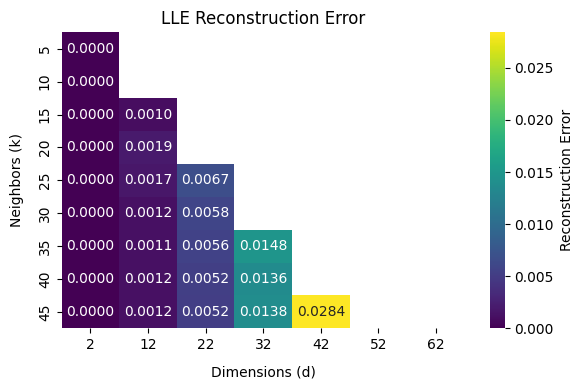

In [9]:
pivot = results_df.pivot(index='k', columns='d', values='error')
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Reconstruction Error'})
plt.title("LLE Reconstruction Error")
plt.xlabel("Dimensions (d)", labelpad=10)
plt.ylabel("Neighbors (k)", labelpad=10)
plt.tight_layout()

# save the plot to pdf
plt.savefig("lle_reconstruction_error.pdf", format="pdf")

# show the plot
plt.show()

## Save the best configurations to csv
The eventual aim will be to best classify leaf samples. Thus we want to retain the local geometric embedding, i.e. minimise the reconstruction error, but also minimise the classification error. Since we're dealing with image data, there is scope to allow for higher dimensions. Thus for each dimension, the we will retain the configuration with the lowest number of k. This seems reasonable since the reconstruction error across k for fixed d does not vary greatly.

The only exception will be for d=2, here we will be using k = 15.

In [ ]:
# fit lle with k=15 and d=2
k = 15
d = 2
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=d)
X_embedded = lle.fit_transform(X)

# save to csv
X_embedded_df = pd.DataFrame(X_embedded, columns=[f"PC{i+1}" for i in range(d)])
X_embedded_df.to_csv(f"lle_k{k}_d{d}.csv", index=False)

In [ ]:
# fit lle with k=15 and d=12
k = 15
d = 12
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=d)
X_embedded = lle.fit_transform(X)

# save to csv
X_embedded_df = pd.DataFrame(X_embedded, columns=[f"PC{i+1}" for i in range(d)])
X_embedded_df.to_csv(f"lle_k{k}_d{d}.csv", index=False)

In [ ]:
# fit lle with k=25 and d=22
k = 25
d = 22
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=d)
X_embedded = lle.fit_transform(X)

# save to csv
X_embedded_df = pd.DataFrame(X_embedded, columns=[f"PC{i+1}" for i in range(d)])
X_embedded_df.to_csv(f"lle_k{k}_d{d}.csv", index=False)

In [ ]:
# fit lle with k=35 and d=32
k = 35
d = 32
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=d)
X_embedded = lle.fit_transform(X)

# save to csv
X_embedded_df = pd.DataFrame(X_embedded, columns=[f"PC{i+1}" for i in range(d)])
X_embedded_df.to_csv(f"lle_k{k}_d{d}.csv", index=False)

In [ ]:
# fit lle with k=45 and d=42
k = 45
d = 42
lle = LocallyLinearEmbedding(n_neighbors=k, n_components=d)
X_embedded = lle.fit_transform(X)

# save to csv
X_embedded_df = pd.DataFrame(X_embedded, columns=[f"PC{i+1}" for i in range(d)])
X_embedded_df.to_csv(f"lle_k{k}_d{d}.csv", index=False)